In [1]:
# 1. Add paths and import env variables
import sys
from os import environ
database_uri = environ['DATABASE_URI']
sys.path.insert(0, '/app')
sys.path.insert(0, '/data')

In [2]:
# 2. Imports and topic setup
import string
import spacy
import numpy as np
import matplotlib.pyplot as plt

from pytictoc import TicToc

from sqlalchemy import create_engine, ForeignKey, Column, Integer, String, Text, select
from sqlalchemy.orm import declarative_base, relationship, Session

from articles_orm import Base, Article, ArticleFeatures
from utils import read_file_content, money_merger, print_topics, plot_top_words, get_recommendation

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel


topic_list = read_file_content('/data/topics.txt')
en_stopwords = read_file_content('/data/stopwords_en.txt')
t = TicToc()

print(topic_list)

['crypto', 'bitcoin', 'covid', 'vaccine', 'startups', 'technology', 'e-commerce', 'Nokia', 'Apple', 'Microsoft']


In [3]:
# 3. Setup engine to database.
engine = create_engine(database_uri)

In [4]:
# 4. Query all articles
with Session(engine) as session:
    articles = session.query(Article).all()
    articles_features = session.query(ArticleFeatures).all()
print(len(articles))
print(len(articles_features))
print(articles[-1].id)
print(articles_features[-1].id)

746
746
746
746


In [5]:
# 5. Save lemmatized texts from article_features to list for later TfIdf and BoW
lemmatized_texts = [article_features.lemmatized_text for article_features in articles_features]

In [6]:
# 6. TfIdf with trigrams
vectorizer = TfidfVectorizer(ngram_range=(1,3), 
                             sublinear_tf=True, 
                             use_idf=True, 
                             stop_words=en_stopwords, 
                             min_df=2, 
                             max_df=0.85)
t.tic()
tf = vectorizer.fit_transform(lemmatized_texts)
t.toc("Tfidf fitted in")
feature_names = vectorizer.get_feature_names()
# Print the shape of tf
print(tf.shape)
print(feature_names)
print(tf)

Tfidf fitted in 0.577551 seconds.
(746, 45818)
['aapl', 'aaron', 'aaron rupar', 'aaron rupar atrupar', 'ab', 'ab electrolux', 'ab electrolux abb', 'ab express', 'ab express logic', 'abandon', 'abate', 'abb', 'abb aibrian', 'abb aibrian alibaba', 'abb aibrian analog', 'abbott', 'abc', 'abc news', 'abide', 'ability', 'ability analyze', 'ability analyze process', 'ability build', 'ability capture', 'ability capture streaming', 'ability change', 'ability connect', 'ability create', 'ability detect', 'ability download', 'ability entrepreneur', 'ability entrepreneur capital', 'ability grow', 'ability print', 'ability print pdf', 'ability raise', 'ability react', 'ability stand', 'ability work', 'abn', 'abn verizon', 'abn verizon wireless', 'abroad', 'abruptly', 'absence', 'absent', 'absolute', 'absolute good', 'absolute good cloud', 'absolute term', 'absolute term gdp', 'absolutely', 'absorb', 'abstract', 'abstract global', 'abstract global internet', 'abundance', 'abundant', 'abuse', 'abuse

In [7]:
# 7.1. Principal Component Analysis 
# performed through Singular Value Decomposition applied on a TfIdf model renders Latent Semantic Indexing
svd5 = TruncatedSVD(n_components=5, random_state=289925)
svd10 = TruncatedSVD(n_components=10, random_state=289925)
svd50 = TruncatedSVD(n_components=50, random_state=289925)
svd200 = TruncatedSVD(n_components=200, random_state=289925)
svd1000 = TruncatedSVD(n_components=1000, random_state=289925)

t.tic()
svd5.fit(tf.toarray())
t.toc("PCA5 fitted in")
t.tic()
svd10.fit(tf.toarray())
t.toc("PCA10 fitted in")
t.tic()
svd50.fit(tf.toarray())
t.toc("PCA50 fitted in")
t.tic()
svd200.fit(tf.toarray())
t.toc("PCA200 fitted in")
t.tic()
svd1000.fit(tf.toarray())
t.toc("PCA1000 fitted in")

t.tic()
tf_svd5 = svd5.transform(tf)
t.toc("PCA5 transformed in")
t.tic()
tf_svd10 = svd10.transform(tf)
t.toc("PCA10 transformed in")
t.tic()
tf_svd50 = svd50.transform(tf)
t.toc("PCA50 transformed in")
t.tic()
tf_svd200 = svd200.transform(tf)
t.toc("PCA200 transformed in")
t.tic()
tf_svd1000 = svd1000.transform(tf)
t.toc("PCA1000 transformed in")

print(svd5.components_.shape)
print(tf_svd5.shape)
print(svd10.components_.shape)
print(tf_svd10.shape)
print(svd50.components_.shape)
print(tf_svd50.shape)

PCA5 fitted in 4.281068 seconds.
PCA10 fitted in 1.979798 seconds.
PCA50 fitted in 2.500098 seconds.
PCA200 fitted in 4.371621 seconds.
PCA1000 fitted in 33.021514 seconds.
PCA5 transformed in 0.001780 seconds.
PCA10 transformed in 0.002645 seconds.
PCA50 transformed in 0.011674 seconds.
PCA200 transformed in 0.052084 seconds.
PCA1000 transformed in 0.146315 seconds.
(5, 45818)
(746, 5)
(10, 45818)
(746, 10)
(50, 45818)
(746, 50)


In [8]:
# 7.2. Nonnegative Matrix Factorization with Kullback-Leibler divergence equaling to pLSI 
nmf5 = NMF(n_components=5, init='nndsvda', beta_loss='kullback-leibler', solver='mu', random_state=289925)
nmf10 = NMF(n_components=10, init='nndsvda', beta_loss='kullback-leibler', solver='mu', random_state=289925)
nmf50 = NMF(n_components=50, init='nndsvda', beta_loss='kullback-leibler', solver='mu', random_state=289925)
nmf200 = NMF(n_components=200, init='nndsvda', beta_loss='kullback-leibler', solver='mu', random_state=289925)

t.tic()
nmf5.fit(tf)
t.toc("NMF5 fitted in")
t.tic()
nmf10.fit(tf)
t.toc("NMF10 fitted in")
t.tic()
nmf50.fit(tf)
t.toc("NMF50 fitted in")
t.tic()
nmf200.fit(tf)
t.toc("NMF200 fitted in")

t.tic()
tf_nmf5 = nmf5.transform(tf)
t.toc("NMF5 transformed in")
t.tic()
tf_nmf10 = nmf10.transform(tf)
t.toc("NMF10 transformed in")
t.tic()
tf_nmf50 = nmf50.transform(tf)
t.toc("NMF50 transformed in")
t.tic()
tf_nmf200 = nmf200.transform(tf)
t.toc("NMF200 transformed in")

print(nmf5.components_.shape)
print(tf_nmf5.shape)
print(nmf10.components_.shape)
print(tf_nmf10.shape)
print(nmf50.components_.shape)
print(tf_nmf50.shape)

NMF5 fitted in 2.281077 seconds.
NMF10 fitted in 2.484271 seconds.
NMF50 fitted in 6.823938 seconds.
NMF200 fitted in 18.993661 seconds.
NMF5 transformed in 0.312675 seconds.
NMF10 transformed in 0.539842 seconds.
NMF50 transformed in 0.716378 seconds.
NMF200 transformed in 2.041208 seconds.
(5, 45818)
(746, 5)
(10, 45818)
(746, 10)
(50, 45818)
(746, 50)


In [9]:
# 7.03 Fit CountVectorizer for LDA
cnt_vectorizer = CountVectorizer(ngram_range=(1,3), stop_words=en_stopwords, min_df=2, max_df=0.85)
cnt_tf = cnt_vectorizer.fit_transform(lemmatized_texts)
cnt_feature_names = cnt_vectorizer.get_feature_names()

In [10]:
# 7.3. Latent Dirichlet Allocation
lda5 = LatentDirichletAllocation(n_components=5, learning_method='online', random_state=289925)
lda10 = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=289925)
lda50 = LatentDirichletAllocation(n_components=50, learning_method='online', random_state=289925)
lda200 = LatentDirichletAllocation(n_components=200, learning_method='online', random_state=289925)

t.tic()
lda5.fit(cnt_tf)
t.toc("LDA5 fitted in")
t.tic()
lda10.fit(cnt_tf)
t.toc("LDA10 fitted in")
t.tic()
lda50.fit(cnt_tf)
t.toc("LDA50 fitted in")
t.tic()
lda200.fit(cnt_tf)
t.toc("LDA200 fitted in")

t.tic()
tf_lda5 = lda5.transform(cnt_tf)
t.toc("LDA5 transformed in")
t.tic()
tf_lda10 = lda10.transform(cnt_tf)
t.toc("LDA10 transformed in")
t.tic()
tf_lda50 = lda50.transform(cnt_tf)
t.toc("LDA50 transformed in")
t.tic()
tf_lda200 = lda200.transform(cnt_tf)
t.toc("LDA200 transformed in")

print(lda5.components_.shape)
print(tf_lda5.shape)
print(lda10.components_.shape)
print(tf_lda10.shape)
print(lda50.components_.shape)
print(tf_lda50.shape)

LDA5 fitted in 1.624871 seconds.
LDA10 fitted in 4.111459 seconds.
LDA50 fitted in 18.986605 seconds.
LDA200 fitted in 48.381567 seconds.
LDA5 transformed in 0.071896 seconds.
LDA10 transformed in 0.182115 seconds.
LDA50 transformed in 0.322180 seconds.
LDA200 transformed in 1.084136 seconds.
(5, 45818)
(746, 5)
(10, 45818)
(746, 10)
(50, 45818)
(746, 50)


In [11]:
import datetime
print(articles[0].title, articles[45].title, sep='\n')
dt0 = datetime.datetime.strptime(articles[0].publication_date, '%Y-%m-%d %H:%M:%S')
dt45 = datetime.datetime.strptime(articles[45].publication_date, '%Y-%m-%d %H:%M:%S')
print(dt0, dt45, sep='\n')
delta = abs(dt0-dt45)
delta.total_seconds()/86400

Poly Network Hackers Return $256 Million in Stolen Crypto Funds
Privateum Partners with Luna PR to Promote New FinTech Crypto Platform
2021-08-11 13:10:00
2021-08-11 16:56:00


0.15694444444444444

In [12]:
#8. Recommend an article
source_article_id = 0
similarity_method = cosine_similarity
## Clear Tfidf
get_recommendation(source_article_id, articles, tf, similarity_method, text_repr="Clear TfIdf")

print()
## PCA
get_recommendation(source_article_id, articles, tf_svd5, similarity_method, text_repr="PCA5")
get_recommendation(source_article_id, articles, tf_svd10, similarity_method, text_repr="PCA10")
get_recommendation(source_article_id, articles, tf_svd50, similarity_method, text_repr="PCA50")
get_recommendation(source_article_id, articles, tf_svd200, similarity_method, text_repr="PCA200")
get_recommendation(source_article_id, articles, tf_svd1000, similarity_method, text_repr="PCA1000")

print()
## NMF
get_recommendation(source_article_id, articles, tf_nmf5, similarity_method, text_repr="NMF5")
get_recommendation(source_article_id, articles, tf_nmf10, similarity_method, text_repr="NMF10")
get_recommendation(source_article_id, articles, tf_nmf50, similarity_method, text_repr="NMF50")
get_recommendation(source_article_id, articles, tf_nmf200, similarity_method, text_repr="NMF200")

print()
## LDA
get_recommendation(source_article_id, articles, tf_lda5, similarity_method, text_repr="LDA5")
get_recommendation(source_article_id, articles, tf_lda10, similarity_method, text_repr="LDA10")
get_recommendation(source_article_id, articles, tf_lda50, similarity_method, text_repr="LDA50")
get_recommendation(source_article_id, articles, tf_lda200, similarity_method, text_repr="LDA200")

==Clear TfIdf==
Source article:
Article(topic=crypto, title=Poly Network Hackers Return $256 Million in Stolen Crypto Funds, description=Less than a day after wreaking one of the biggest crypto thefts in history, hackers have reportedly refunded more than a third of their loot. url=https://gizmodo.com/hackers-behind-historic-crypto-heist-have-reportedly-re-1847465401)
Recommended articles:
1 || ArticleID:45 ||
Privateum Partners with Luna PR to Promote New FinTech Crypto Platform || Similarity: 99.1% ||
2 || ArticleID:29 ||
Titan launches actively managed crypto portfolio for US investors || Similarity: 15.6% ||
3 || ArticleID:5 ||
Poly Network pleads for hackers to return assets after $611 million crypto heist - and they start to do so || Similarity: 13.9% ||
4 || ArticleID:84 ||
This Bank Is a True Growth Stock || Similarity: 13.7% ||
5 || ArticleID:21 ||
The hacker behind a giant cryptocurrency heist is returning stolen funds || Similarity: 13.1% ||

==PCA5==
Source article:
Article

In [16]:
nlp = spacy.load("en_core_web_md")
mtxt0 = nlp(articles[0].maintext)
mtxt1 = nlp(articles[45].maintext)
print(mtxt0.similarity(mtxt1))

0.9553509036139183


In [49]:
# 9.1. Display 15 top words in each topic in each method
print("==PCA==")
print("==5==")
print_topics(svd5, feature_names)
print("==10==")
print_topics(svd10, feature_names)
print("==50==")
print_topics(svd50, feature_names)

print()
print("==NMF==")
print("==5==")
print_topics(nmf5, feature_names)
print("==10==")
print_topics(nmf10, feature_names)
print("==50==")
print_topics(nmf50, feature_names)

print()
print("==LDA==")
print("==5==")
print_topics(lda5, cnt_feature_names)
print("==10==")
print_topics(lda10, cnt_feature_names)
print("==50==")
print_topics(lda50, cnt_feature_names)

==PCA==
==5==
0 company, year, market, business, time, people, well, include, work, technology, share, high, service, vaccine, report, 
1 cookie, cookie policy, happen browser support, service cookie policy, load review, support javascript cookie, block load, review term service, support javascript, javascript cookie block, javascript cookie, review term, block load review, load review term, term service cookie, 
2 circuitpython, adafruit, circuit playground, playground, circuit, arduino, discord, alligator clip, makecode, alligator clip pad, python hardware, alligator, clip pad, python, pad, 
3 vaccine, vaccinate, vaccination, dose, variant, mask, delta, delta variant, people, health, coronavirus, case, disease, mandate, virus, 
4 quarter, profit, second quarter, thursday, rise, market, stock, second, china, earning, chinese, analyst, outlook, year, report, 
==10==
0 company, year, market, business, time, people, well, include, work, technology, share, high, service, vaccine, report, 

40 market, analysis, brand, market research, report, forecast, study, cagr, research, apple, forecast period, market share, news, segment, market size, 
41 app, brand, price, operating profit, store, samsung, level, android, platform, support, medium, card, box, robinhood, memory chip, 
42 office, geeky gadgets, gadgets, geeky, facebook, affiliate, expect, link, ministry, vaccine, microsoft, learn, release, economic, forward statement, 
43 apple, outlook promise turnaround, profit thursday raise, outlook promise, maker nokia report, promise turnaround business, promise turnaround, operating profit thursday, year outlook promise, nokia report strong, equipment maker nokia, maker nokia, battery, airtag, refinitiv, 
44 facebook, attack, ad, brand, social, cyber, medium, security, zuckerberg, gb, agency, nokia, vulnerability, exploit, microsoft exchange, 
45 nikola, battery, milton, coating, airtag, device, statement, samsung, trevor, trevor milton, pfizer, dose, games, second, bitterant, 

9 company, market, profit, rise, year, thursday, quarter, chip, high, china, report, share, second, expect, bank, 
==50==
0 circuitpython, project, adafruit, playground, circuit, circuit playground, join, day, arduino, speaker, instagram, sensor, clip, pad, python, 
1 zoom, share, fund, ark, month, growth, york, economic, stock, gain, wood, ark innovation, innovation, company, large, 
2 xbox, samsung, tablet, galaxy, console, smartphone, nokia, xbox series, game pass, fi, wi fi, wi, uk, krispy, krispy kreme, 
3 system, game, bitcoin, blockchain, cryptos, money, cryptocurrencie, tomorrow, crypto, price, play, ledger, market, reckoning, daily reckoning, 
4 telefonica, fibre, spain, spanish, core earning, virgin media, vila, spanish telecom, ric, virgin, madrid, favourable, britain, uk joint venture, uk joint, 
5 rba, economist, read, australia, week, programme, bond, sydney, bank, buying, economy, decision, bond buying, country, lockdown, 
6 china, qin, ambassador, chinese, washington, f

0

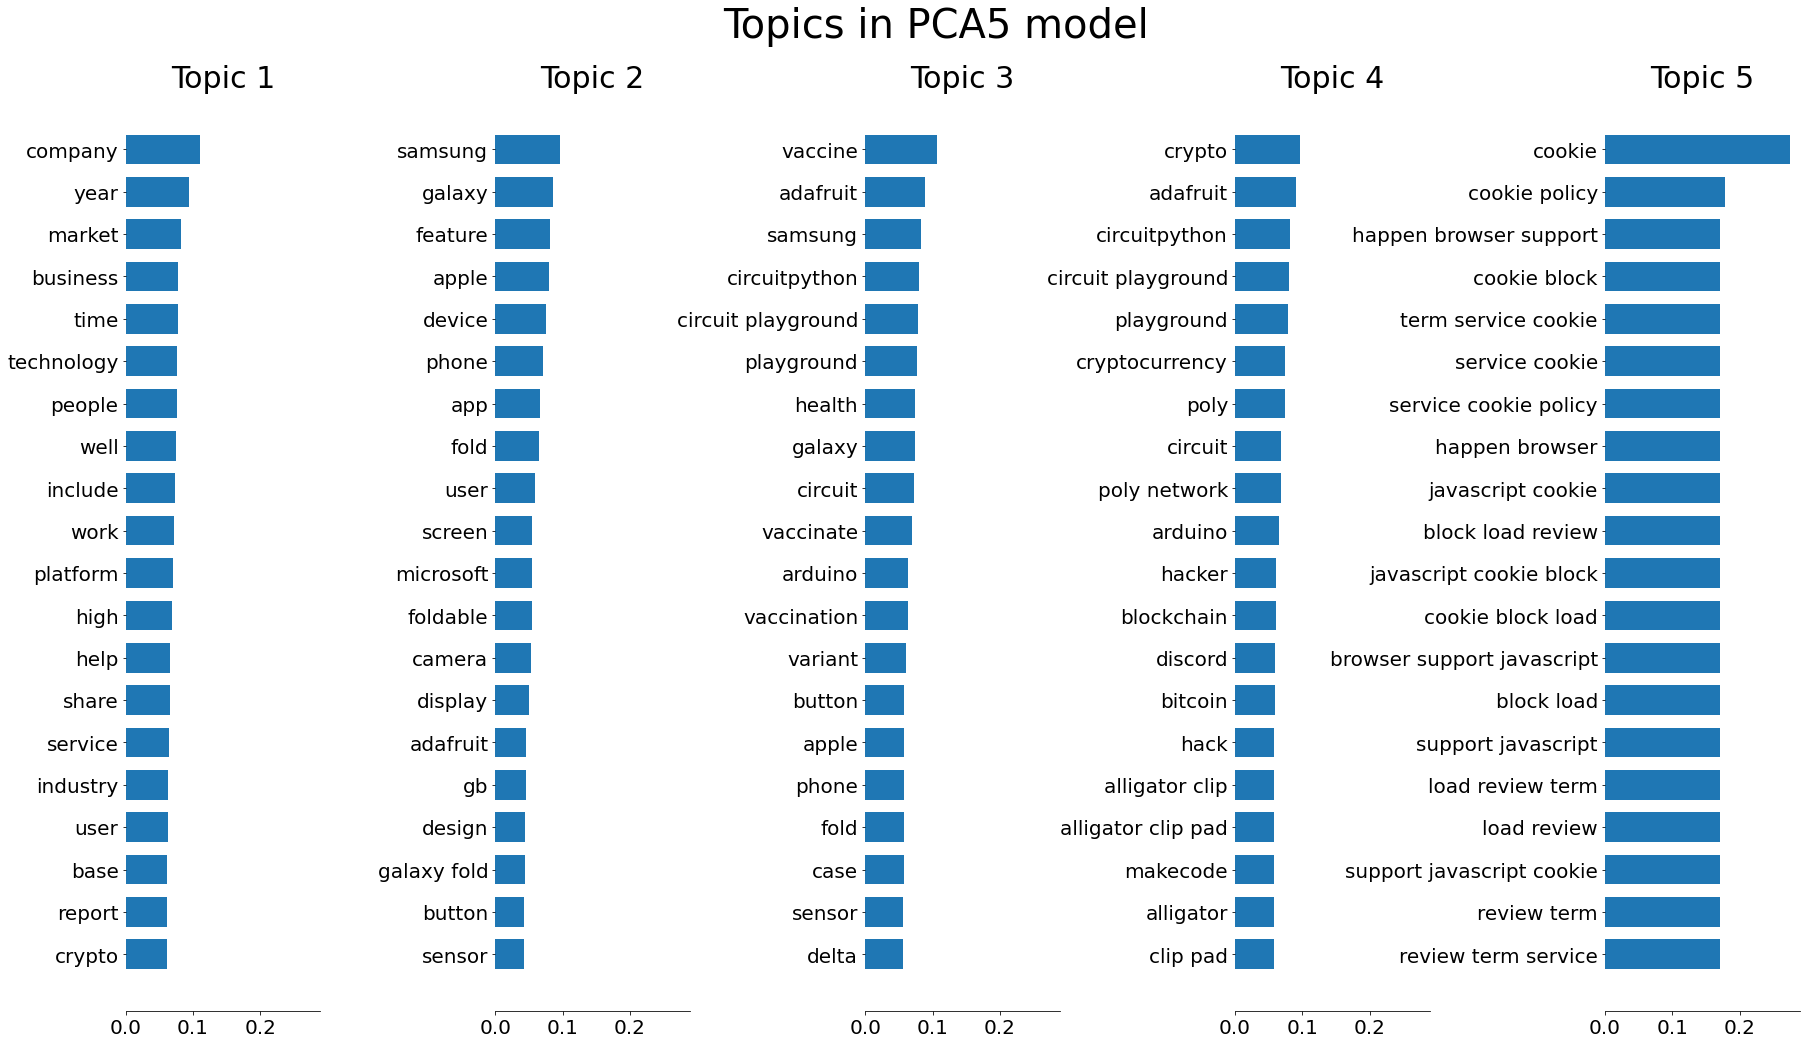

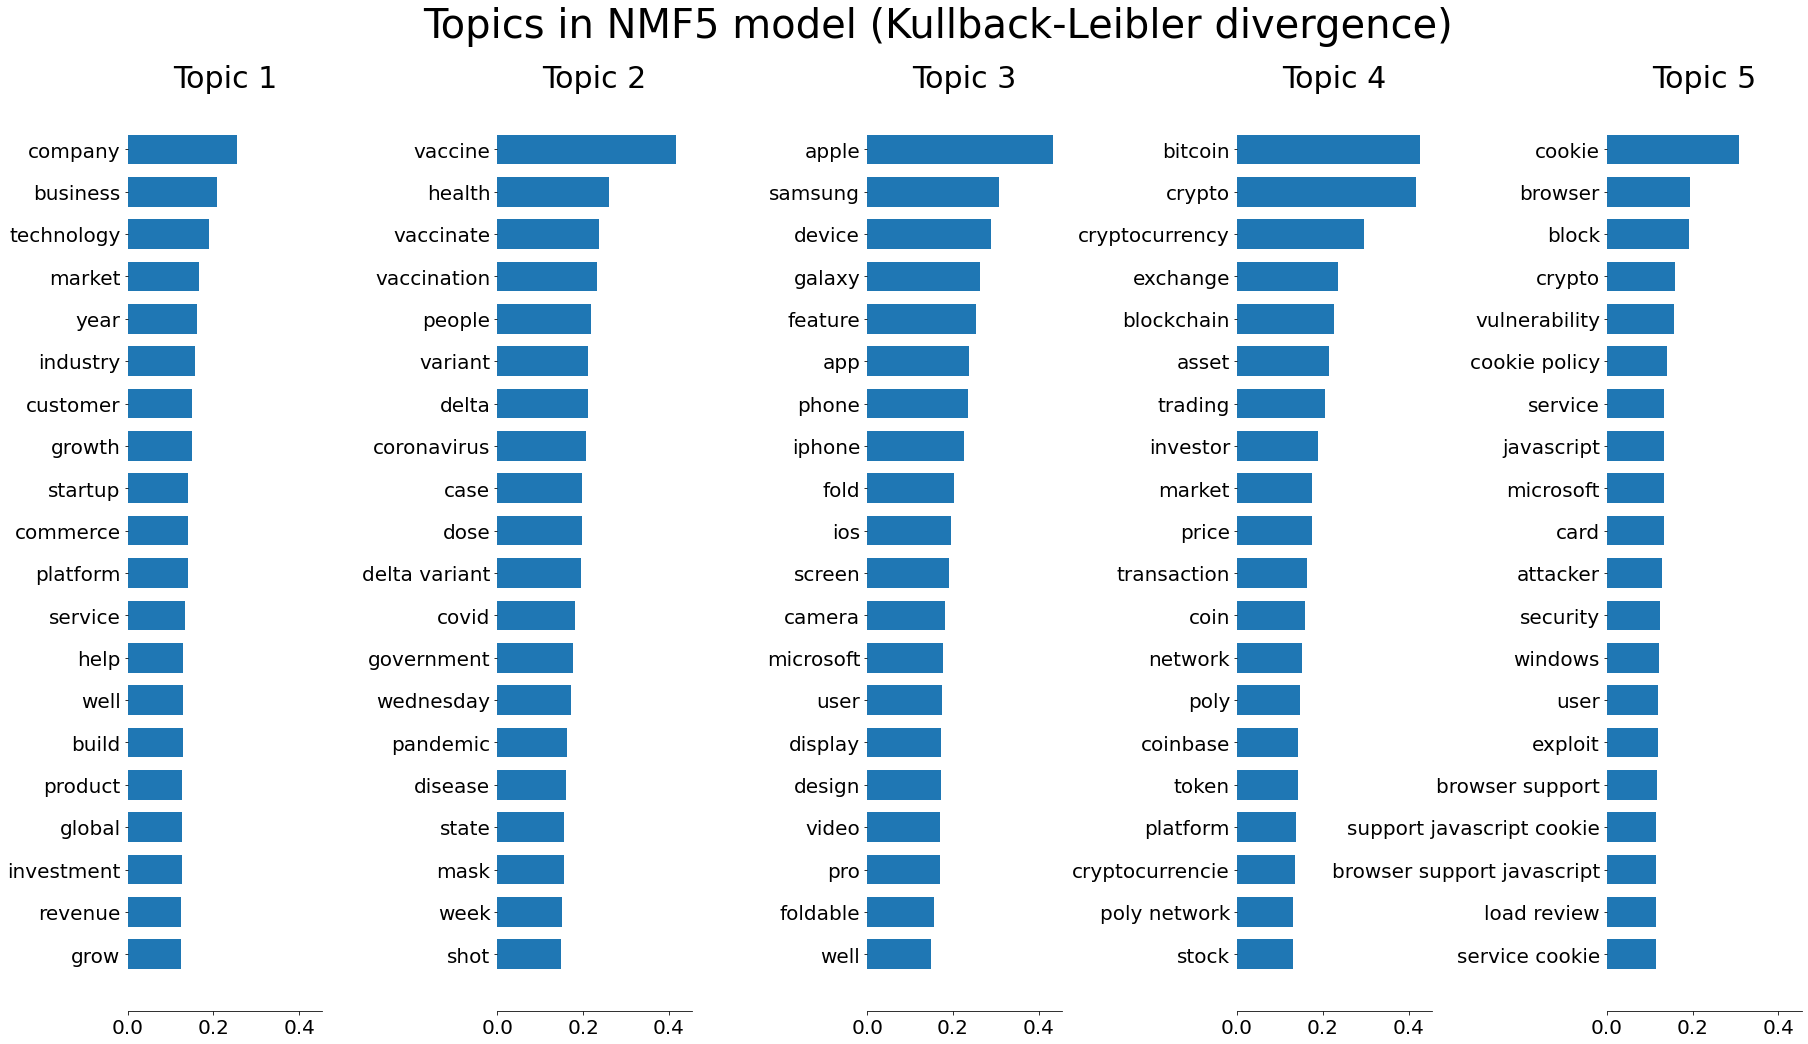

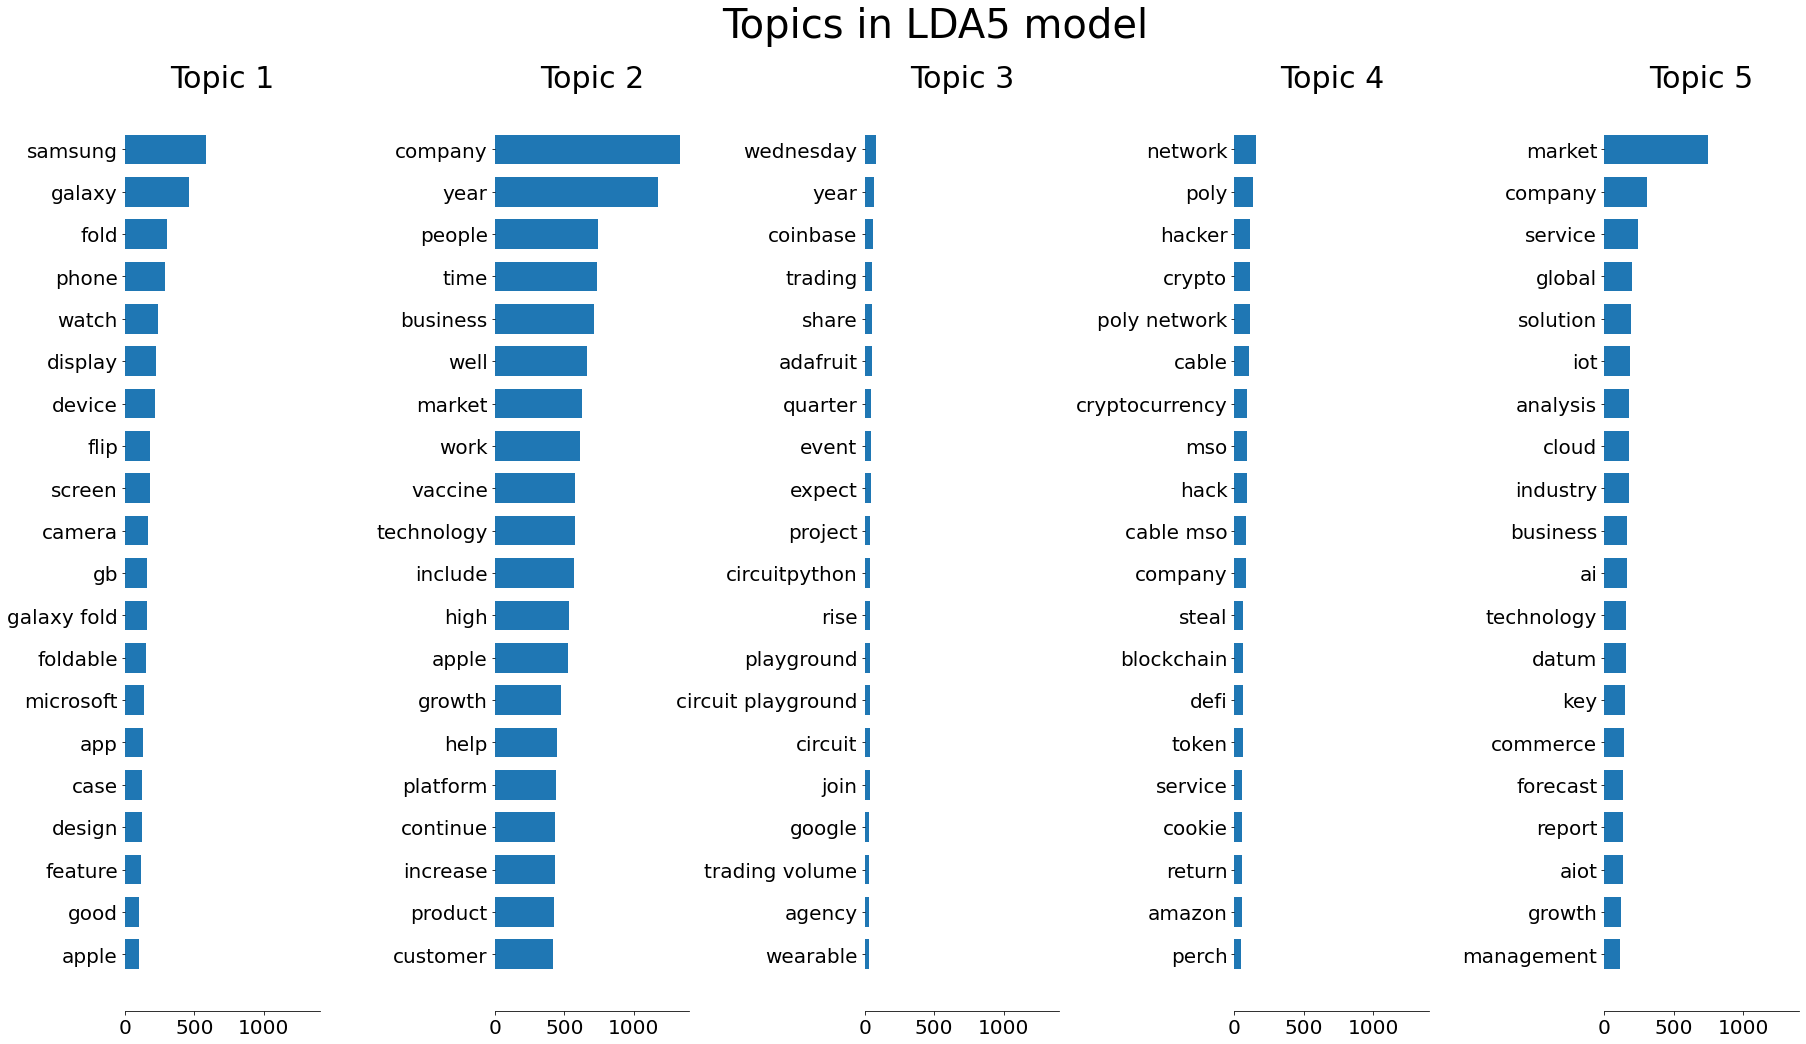

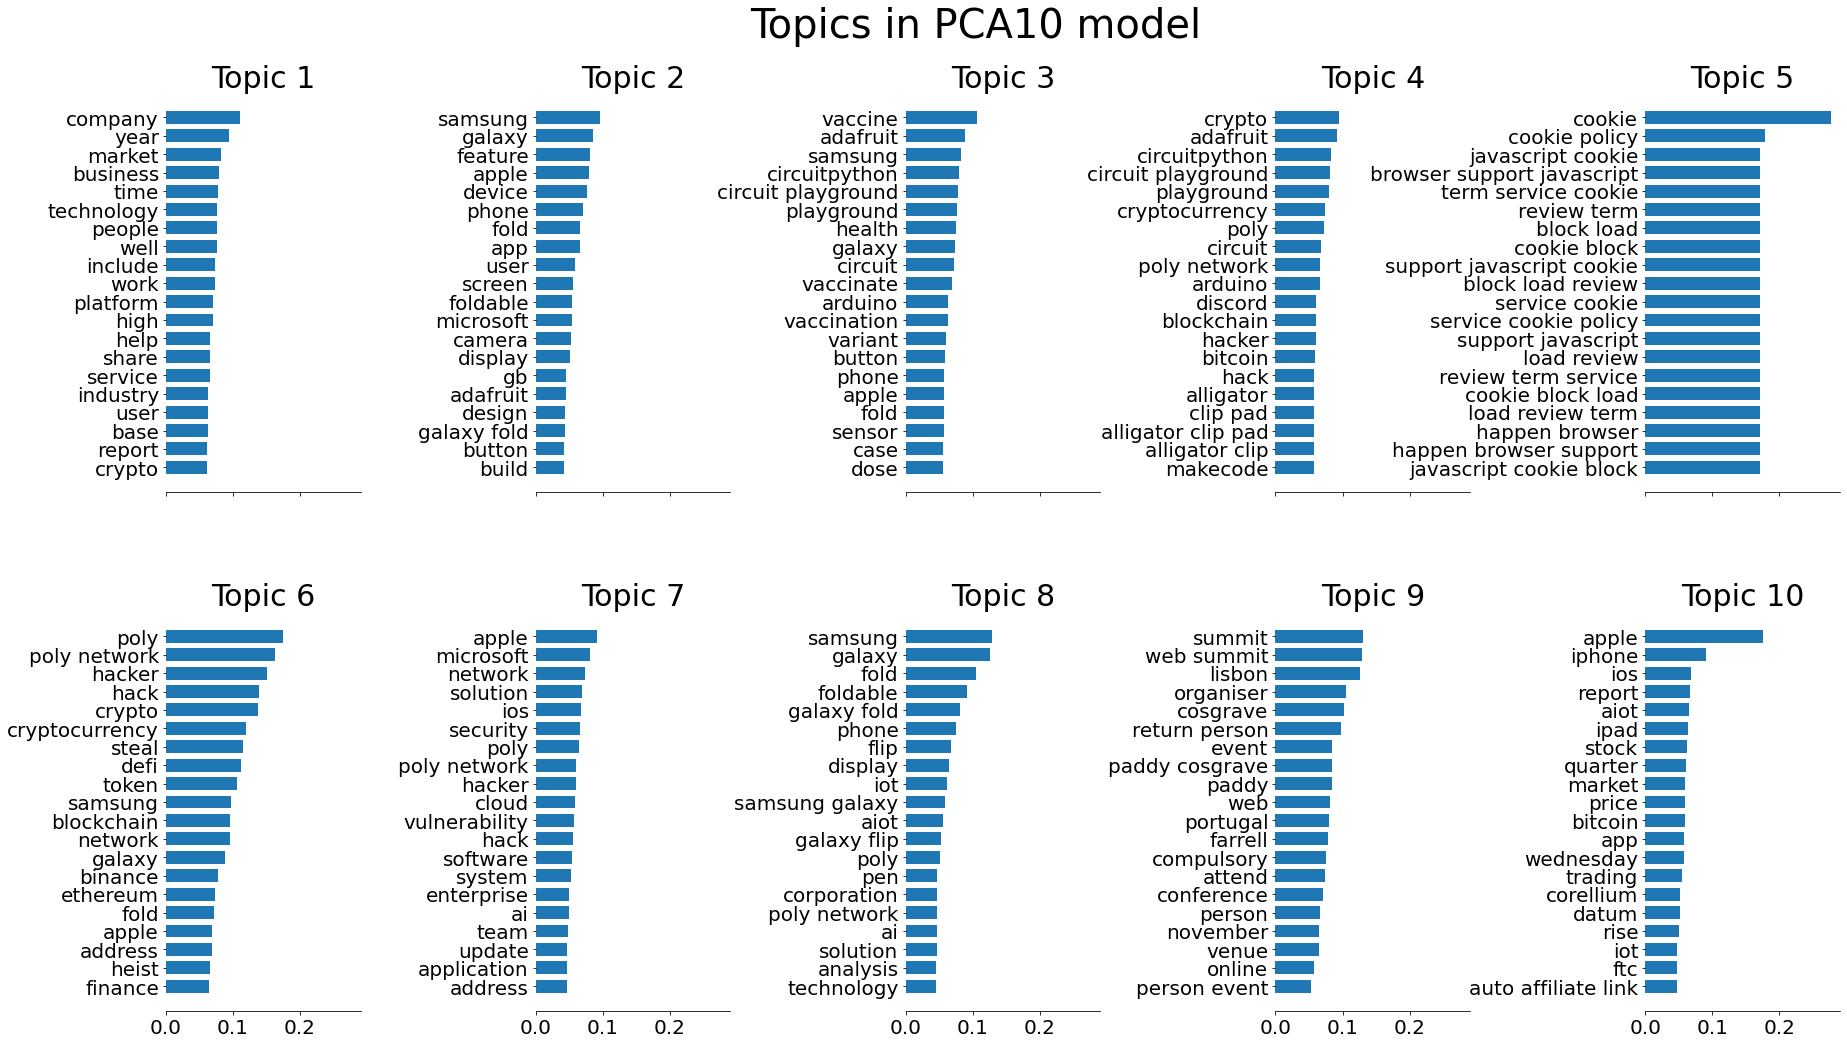

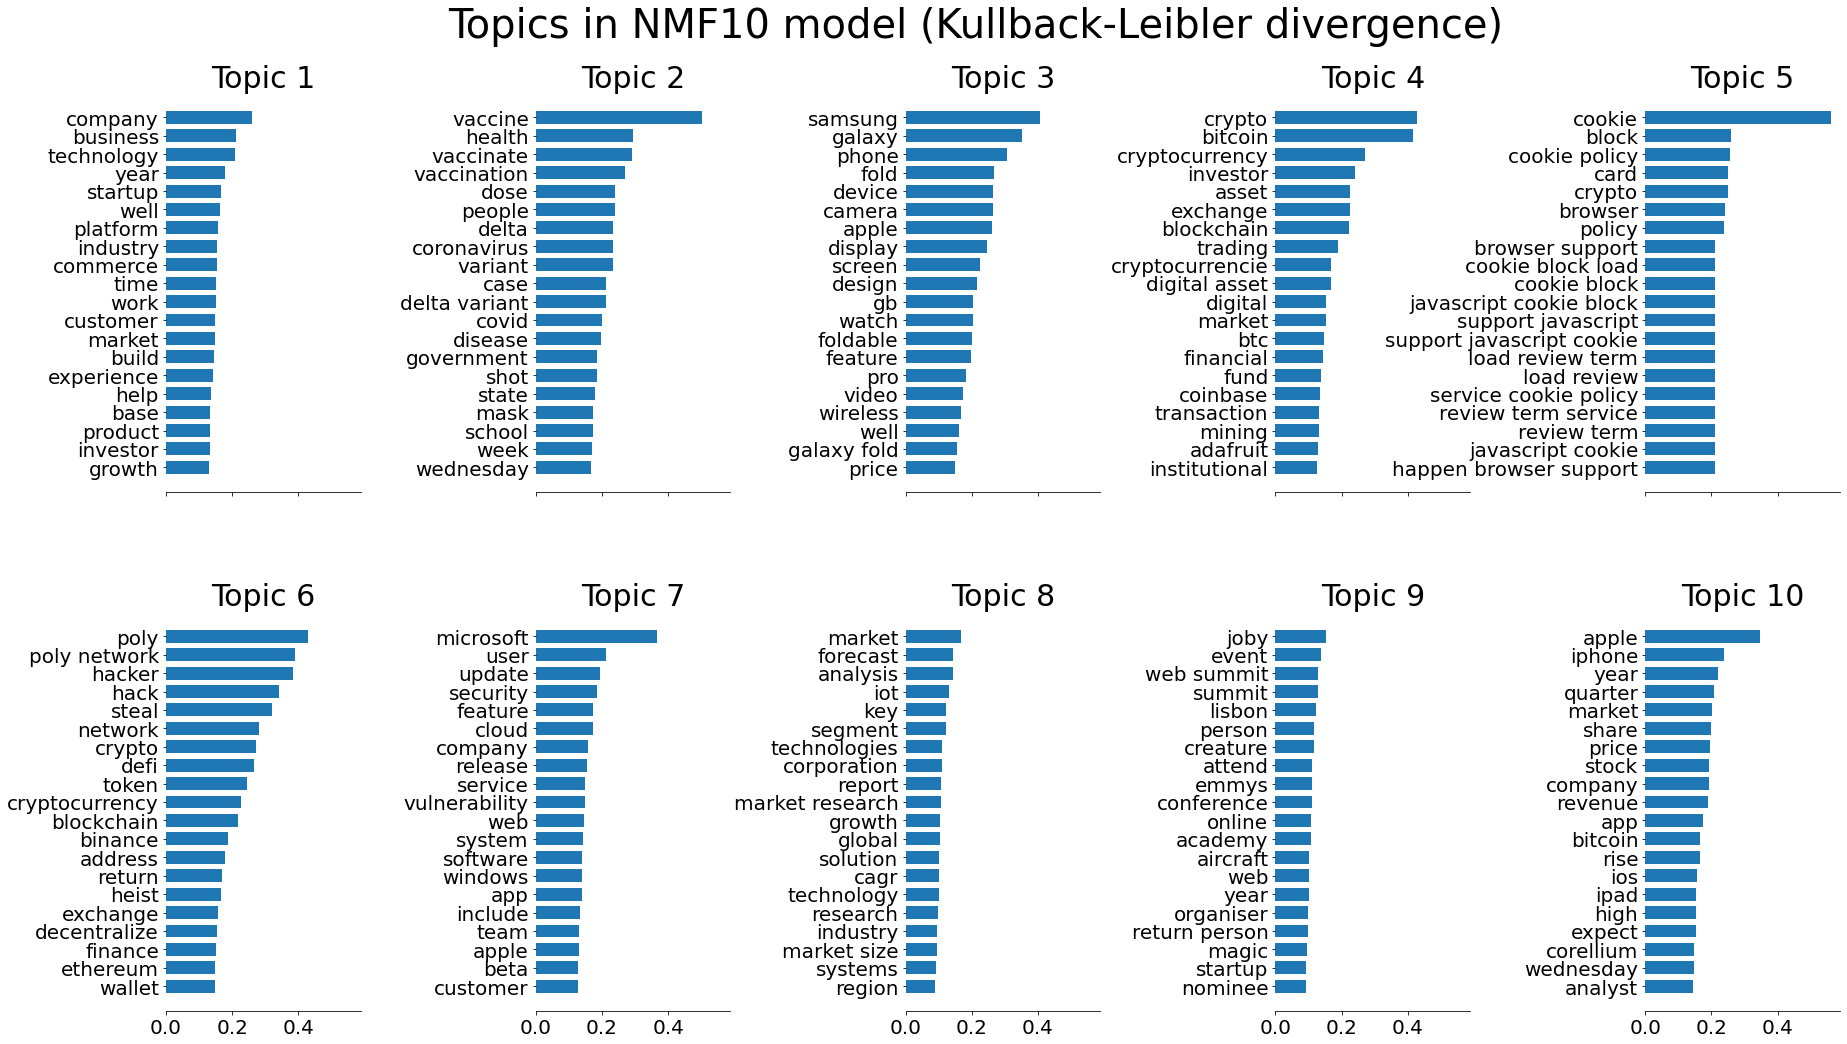

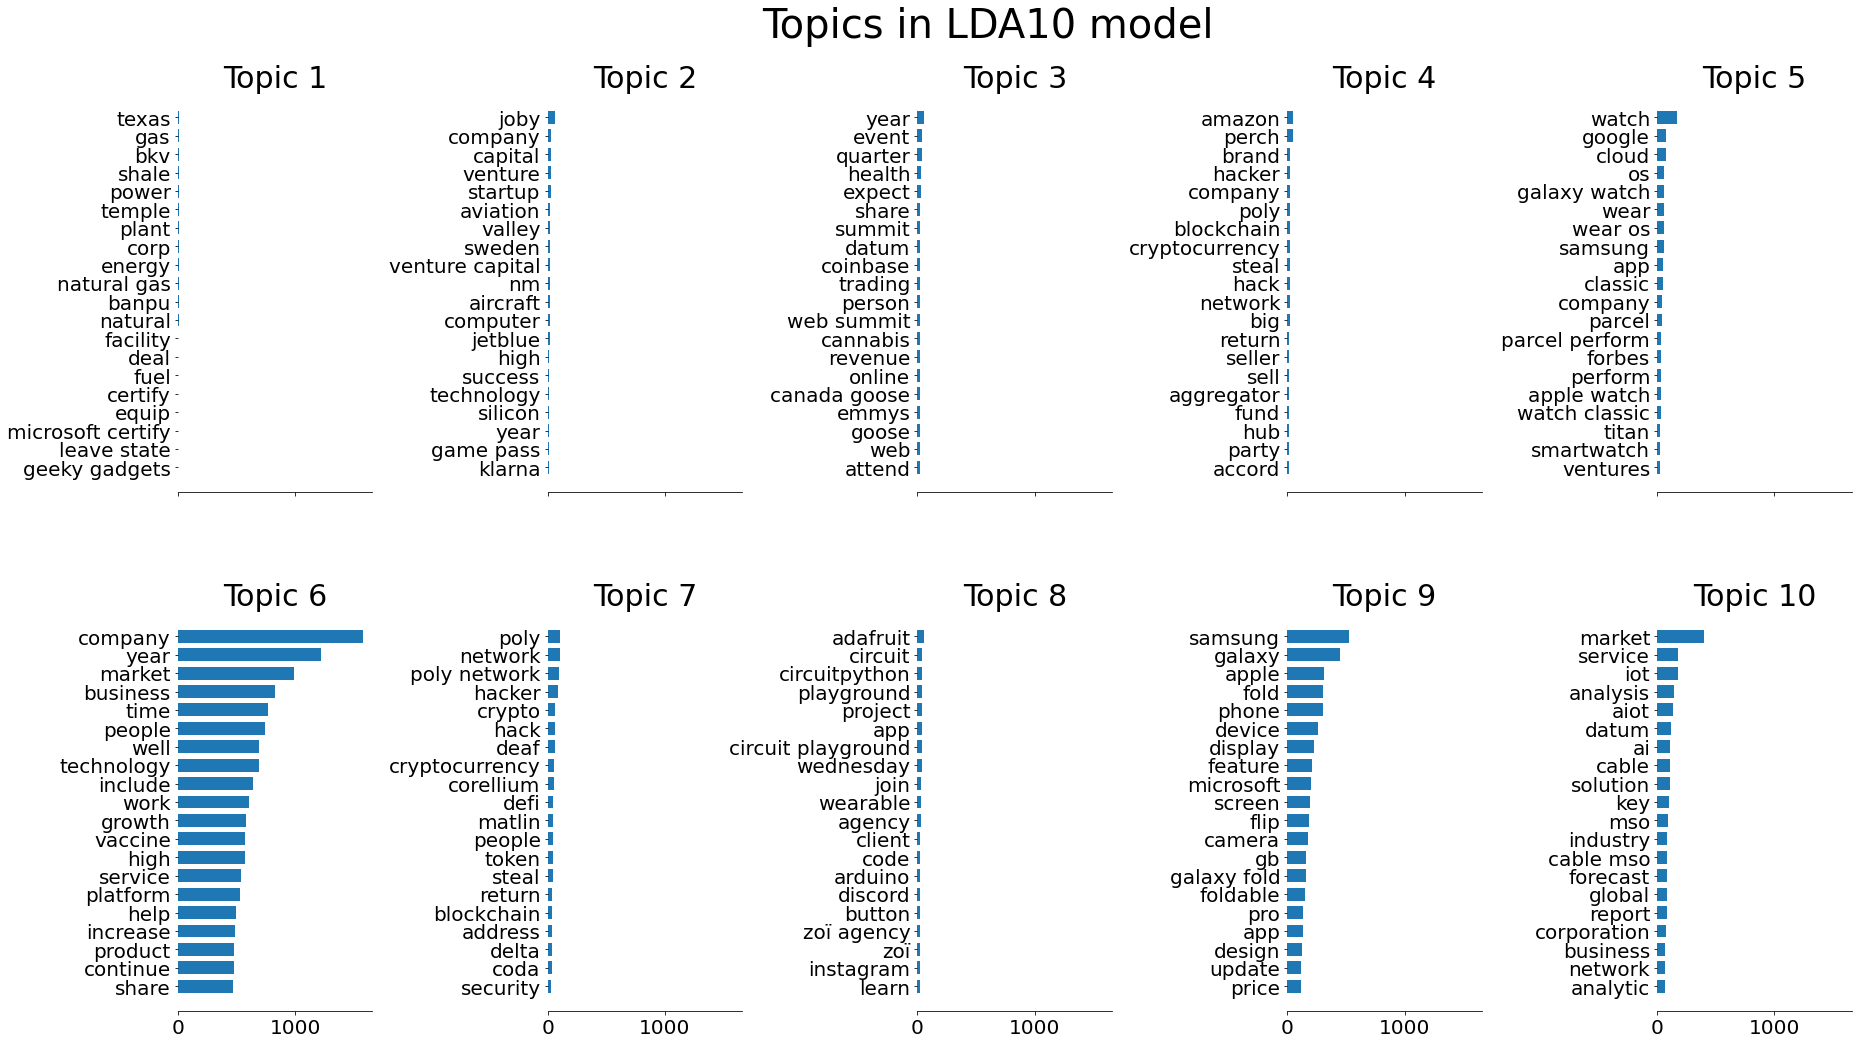

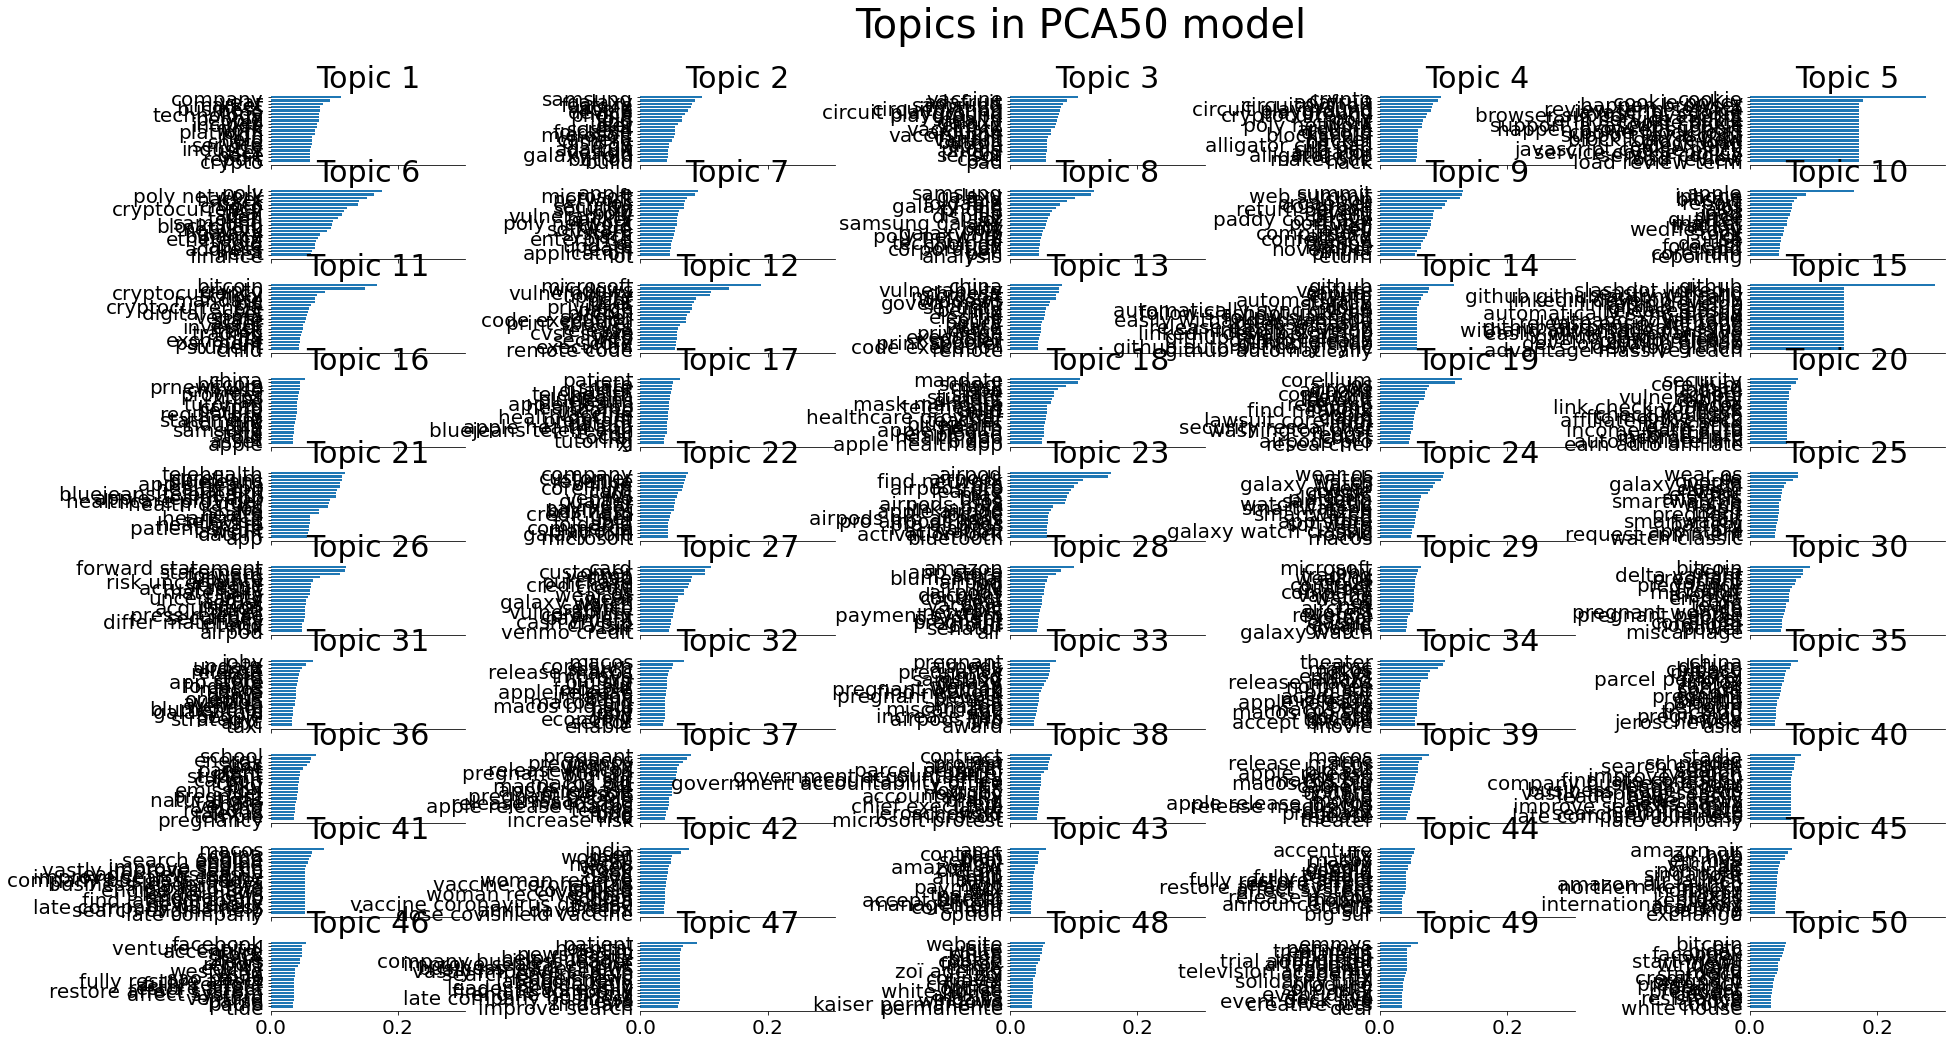

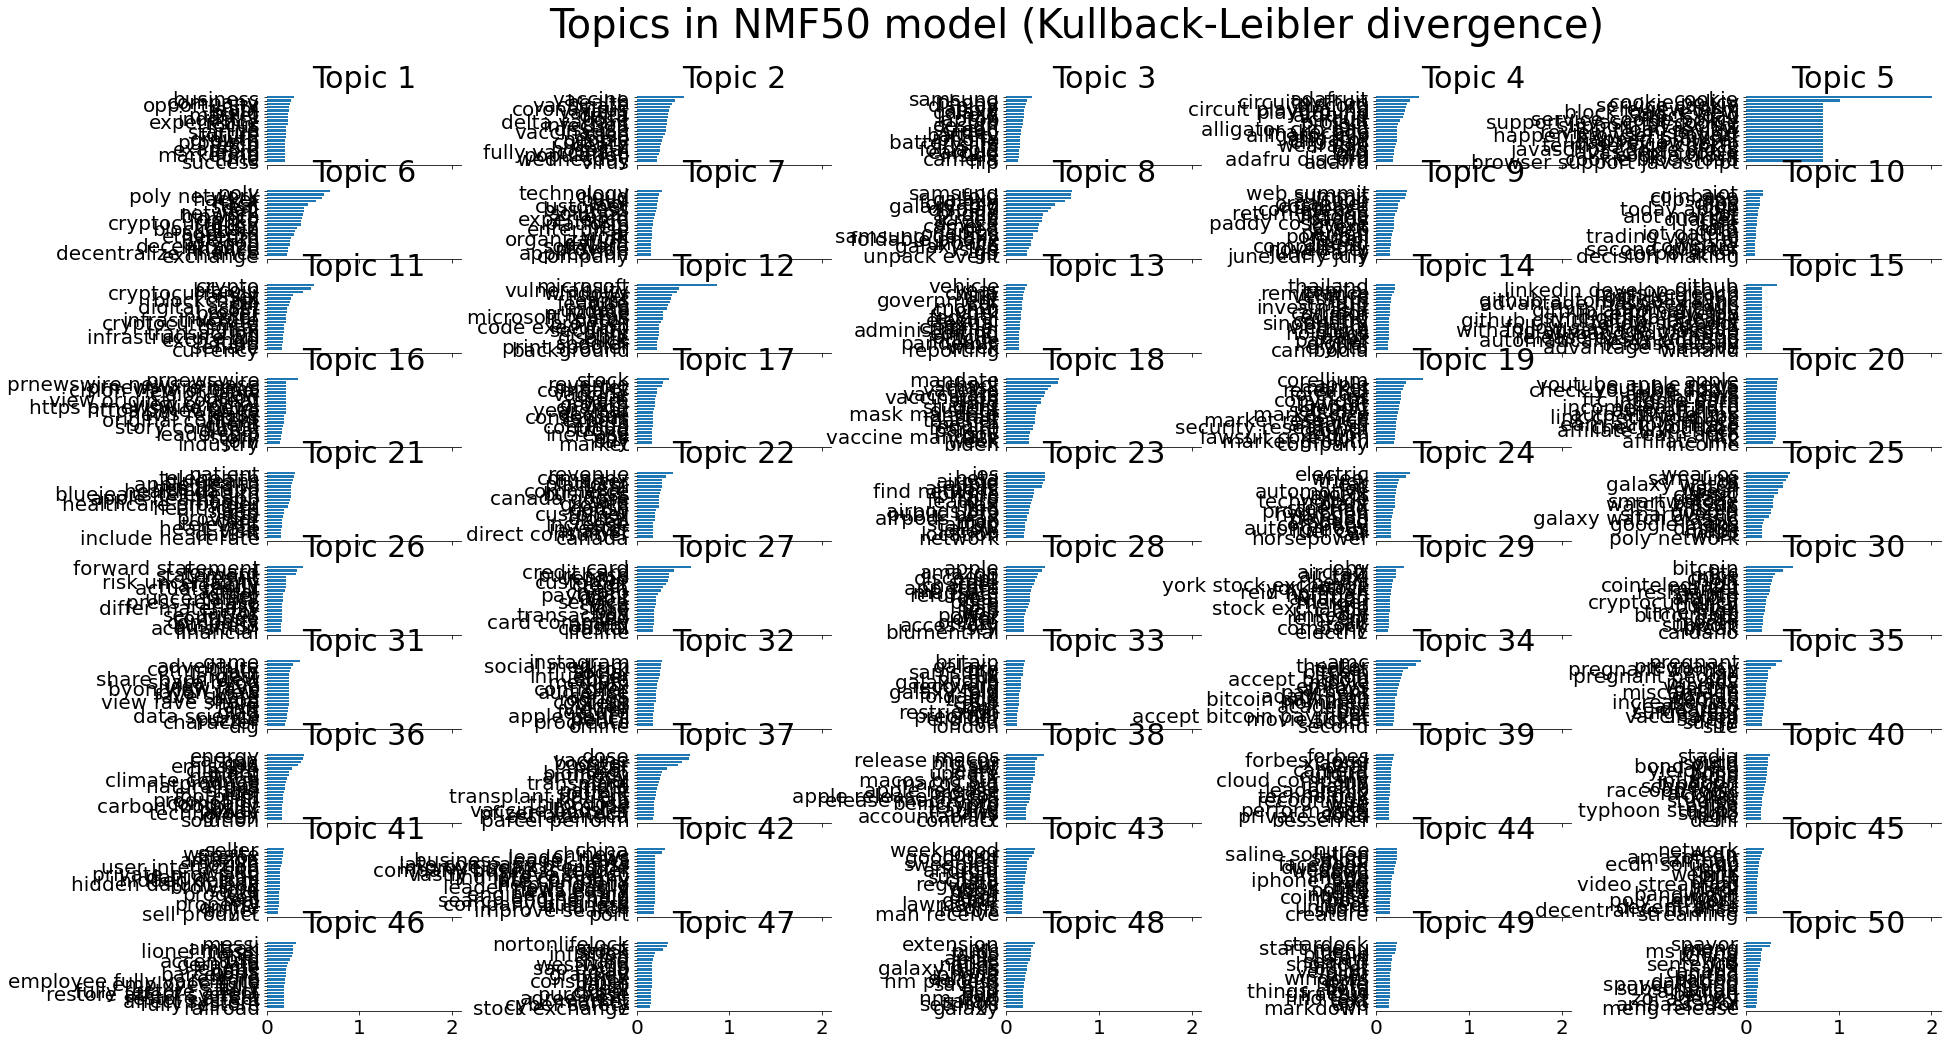

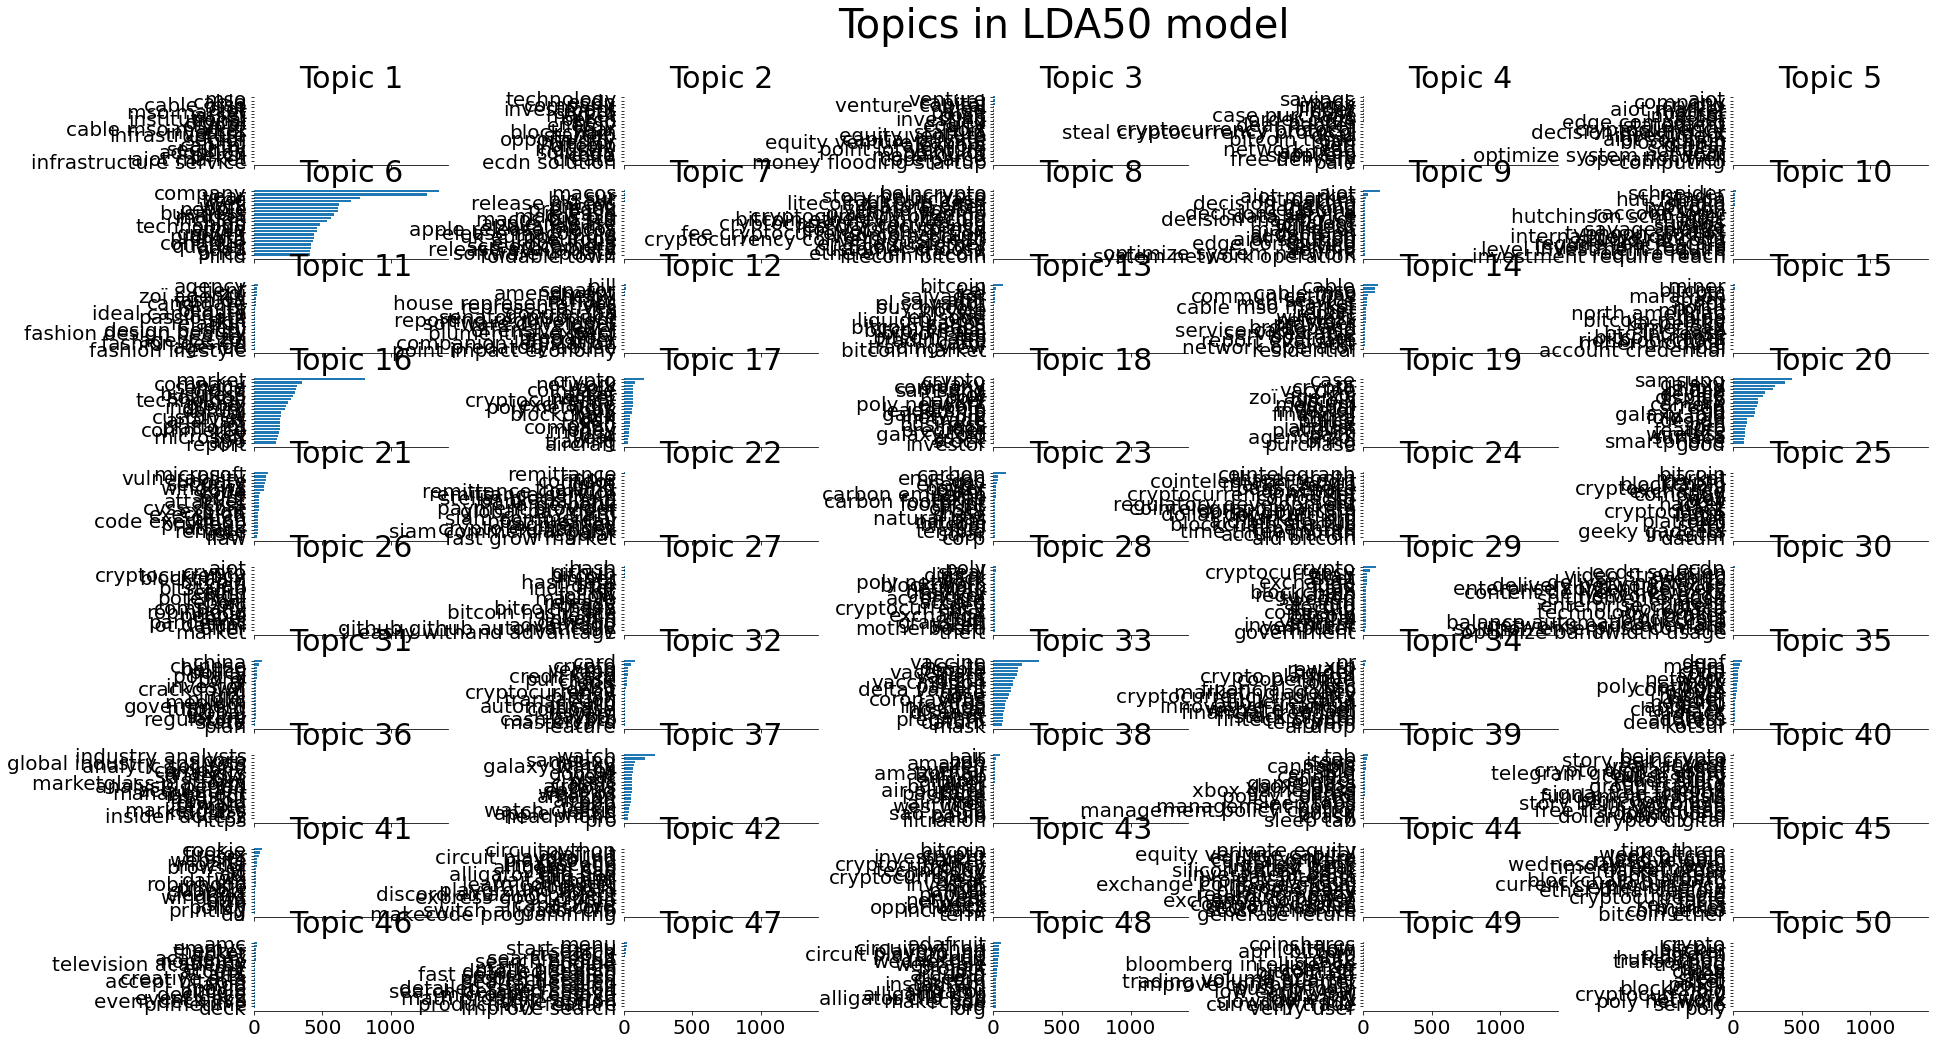

In [14]:
# 9.2. Show topics as vertical plots regarding frequency of tokens 
plot_top_words(svd5, 1,5,feature_names, 20,
                'Topics in PCA5 model')
plot_top_words(nmf5, 1,5,feature_names, 20,
               'Topics in NMF5 model (Kullback-Leibler divergence)')
plot_top_words(lda5, 1,5,cnt_feature_names, 20,
               'Topics in LDA5 model')
print()
plot_top_words(svd10, 2,5,feature_names, 20,
                'Topics in PCA10 model')
plot_top_words(nmf10, 2,5,feature_names, 20,
               'Topics in NMF10 model (Kullback-Leibler divergence)')
plot_top_words(lda10, 2,5,cnt_feature_names, 20,
               'Topics in LDA10 model')
print()
plot_top_words(svd50, 10,5,feature_names, 20,
                'Topics in PCA50 model')
plot_top_words(nmf50, 10,5,feature_names, 20,
               'Topics in NMF50 model (Kullback-Leibler divergence)')
plot_top_words(lda50, 10,5,cnt_feature_names, 20,
               'Topics in LDA50 model')

1 0.3% 0.30316853523254395
2 1.3% 0.3528010845184326
5 3.2% 0.4326815605163574
10 4.8% 0.6701104640960693
50 12.0% 2.8083348274230957
100 17.9% 6.104110479354858
200 27.2% 12.058981895446777
300 35.0% 14.83681869506836
400 41.6% 20.912028789520264
500 47.4% 27.383567333221436
600 52.8% 30.986949920654297
750 60.0% 42.56223654747009
900 66.6% 57.92182683944702
1000 70.8% 66.4053406715393
1100 74.7% 74.54771971702576
1200 78.4% 86.88909840583801
1300 81.9% 96.43226051330566
1400 85.2% 101.79006671905518
1500 88.4% 112.43474006652832


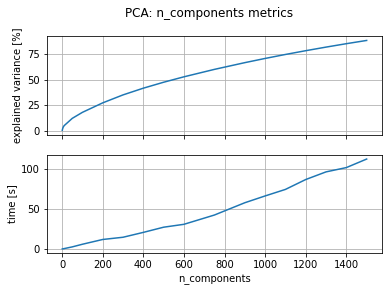

In [8]:
# Compare n_components for TruncatedSVD
range_to_check = [1,2,5,10,50,100,200,300,400,500,600,750,900,1000,1100,1200,1300,1400,1500]
variances = []
times = []
for i in range_to_check:
    test_svd = TruncatedSVD(n_components=i, random_state=289925)
    t0 = time()
    test_svd.fit(tf)
    t = time() - t0
    variances += [test_svd.explained_variance_.sum()*100]
    times += [t]
    print(i, "{:.1%}".format(test_svd.explained_variance_.sum()), t)

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(range_to_check, variances)
ax2.plot(range_to_check, times)
fig.suptitle("PCA: n_components metrics")
plt.xlabel('n_components')
ax1.set_ylabel('explained variance [%]')
ax2.set_ylabel('time [s]')
ax1.grid()
ax2.grid()
plt.show()
fig.savefig('PCA_comp_ev.png')

1 601.3275092825427 1.2668542861938477
2 593.4787173575224 7.174408674240112
5 560.482324545584 10.049501895904541
10 526.4496007125855 9.101725101470947
50 444.69955695240964 23.91863465309143
100 402.17992918320755 45.63147830963135
200 352.580815672398 71.15025568008423
300 322.08777342648 94.47183990478516
400 294.8987131926034 132.41794681549072
500 272.5414894230409 154.7383258342743
600 252.71703363598775 184.75363850593567
750 228.40854503803956 238.2995913028717
900 204.4113808042261 295.6343331336975
1000 190.4590719110527 396.8963768482208
1100 176.5963829123488 595.4965744018555
1200 167.18500368583088 492.2117521762848
1300 154.29793591722822 652.6434516906738
1400 141.8161512140085 744.5207254886627
1500 132.93721160026894 819.5826711654663


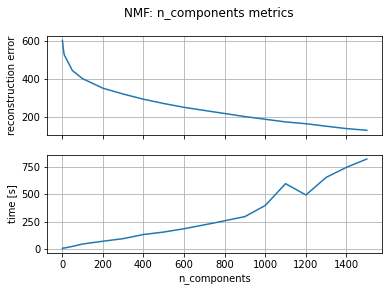

In [10]:
# Compare n_components for NMF
errs = []
times = []
for i in range_to_check:
    test_nmf = NMF(n_components=i, init='nndsvda', beta_loss='kullback-leibler', solver='mu', random_state=289925)
    t0 = time()
    test_nmf.fit(tf)
    t = time() - t0
    errs += [test_nmf.reconstruction_err_]
    times += [t]
    print(i, test_nmf.reconstruction_err_, t)
    
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(range_to_check, errs)
ax2.plot(range_to_check, times)
fig.suptitle("NMF: n_components metrics")
plt.xlabel('n_components')
ax1.set_ylabel('reconstruction error')
ax2.set_ylabel('time [s]')
ax1.grid()
ax2.grid()
plt.show()
fig.savefig('NMF_comp_re.png')

In [ ]:
# Compare n_components for LatentDirichletAllocation
perplexities = []
times = []
for i in range_to_check:
    test_lda = LatentDirichletAllocation(n_components=i, learning_method='online', random_state=289925)
    t0 = time()
    test_lda.fit(cnt_tf)
    t = time() - t0
    perplexities += [test_lda.bound_]
    times += [t]
    print(i, test_lda.bound_, t)

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(range_to_check, perplexities)
ax2.plot(range_to_check, times)
fig.suptitle("LDA: n_components metrics")
plt.xlabel('n_components')
ax1.set_ylabel('perplexity score')
ax2.set_ylabel('time [s]')
ax1.grid()
ax2.grid()
plt.show()
fig.savefig('LDA_comp_ps.png')

In [27]:
# Time all fits using an averaged metric
tfarr = tf.toarray()
cnt_tfarr = cnt_tf.toarray()
print("===TIMING===")
print("=PCA=")
%timeit -r 3 svd5.fit(tfarr)
%timeit -r 3 svd10.fit(tfarr)
%timeit -r 3 svd50.fit(tfarr)
%timeit -r 3 svd200.fit(tfarr)
print("=NMF=")
%timeit -r 3 nmf5.fit(tfarr)
%timeit -r 3 nmf10.fit(tfarr)
%timeit -r 3 nmf50.fit(tfarr)
%timeit -r 3 nmf200.fit(tfarr)
print("=LDA=")
%timeit -r 3 lda5.fit(cnt_tfarr)
%timeit -r 3 lda10.fit(cnt_tfarr)
%timeit -r 3 lda50.fit(cnt_tfarr)
%timeit -r 3 lda200.fit(cnt_tfarr)

print("===OVERALL PERFORMANCE===")
print("=PCA=")
%prun -l _truncated_svd.py svd5.fit(tfarr)
%prun -l _truncated_svd.py svd10.fit(tfarr)
%prun -l _truncated_svd.py svd50.fit(tfarr)
%prun -l _truncated_svd.py svd200.fit(tfarr)
print("=NMF=")
%prun -l _nmf.py nmf5.fit(tfarr)
%prun -l _nmf.py nmf10.fit(tfarr)
%prun -l _nmf.py nmf50.fit(tfarr)
%prun -l _nmf.py nmf200.fit(tfarr)
print("=LDA=")
%prun -l _lda.py lda5.fit(cnt_tfarr)
%prun -l _lda.py lda10.fit(cnt_tfarr)
%prun -l _lda.py lda50.fit(cnt_tfarr)
%prun -l _lda.py lda200.fit(cnt_tfarr)

===TIMING===
=PCA=
8.64 s ± 532 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
11.3 s ± 879 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
18.9 s ± 467 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
30 s ± 363 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
=NMF=
8min 22s ± 14.9 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
6min 21s ± 2.67 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
7min 59s ± 3.73 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
8min 21s ± 4.68 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
=LDA=
22.9 s ± 98.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
29.9 s ± 614 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1min 9s ± 125 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
4min 37s ± 9.32 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
===OVERALL PERFORMANCE===
=PCA=
    =NMF=
    =LDA=
    